# Capstone Project - Traffic Sign Recognition using Convolutional Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import pandas as pd

## Background

Reading traffic signs is an important component of autonomous driving. Autonomous cars need to be able to see the road signs just for the same reasons humans need them. They allow the driver to know the speed they should be traveling, where to stop, and what to be cautious of on the road ahead. Automotive companies could use traffic sign recognition as an aid to human-driven cars as well. Sometimes a human driver can miss a sign alerting them to an upcoming curve or a speed limit change, and the car could remind the driver if it doesn't sense proper responses to signage.

The data to be used for this project comes from the Institute for Neuroinformatik.  It contains 35,000 training images and 12,000 test images of 43 classes of German traffic signs.  The images are 32 x 32 pixels and have 3 color channels. This data can be accessed at the INI website at http://benchmark.ini.rub.de/?section=gtsrb&subsection=news.


## Load and Inspect Data

In [2]:
training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)

image_shape = (X_train[0].shape)

unique, index, counts = np.unique(y_train, return_index = True, return_counts=True)

n_classes = len(unique)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#### Plot Examples of Each Class

Class 0: Speed limit  (20km/h)                               180 samples


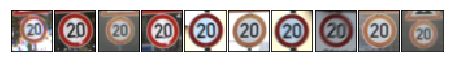

______________________________________________________________________________________

Class 1: Speed limit  (30km/h)                               1980 samples


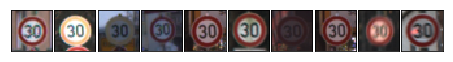

______________________________________________________________________________________

Class 2: Speed limit  (50km/h)                               2010 samples


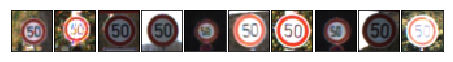

______________________________________________________________________________________

Class 3: Speed limit  (60km/h)                               1260 samples


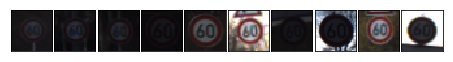

______________________________________________________________________________________

Class 4: Speed limit  (70km/h)                               1770 samples


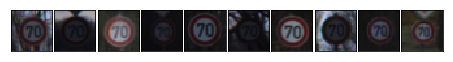

______________________________________________________________________________________

Class 5: Speed limit  (80km/h)                               1650 samples


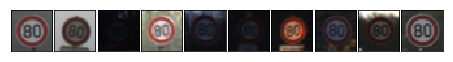

______________________________________________________________________________________

Class 6: End of speed limit  (80km/h)                        360 samples


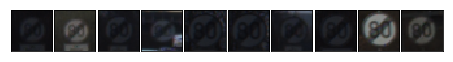

______________________________________________________________________________________

Class 7: Speed limit  (100km/h)                              1290 samples


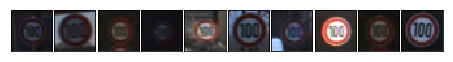

______________________________________________________________________________________

Class 8: Speed limit  (120km/h)                              1260 samples


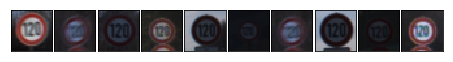

______________________________________________________________________________________

Class 9: No passing                                          1320 samples


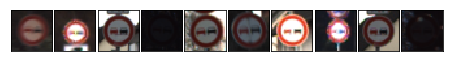

______________________________________________________________________________________

Class 10: No passing for vehicles over 3.5 metric tons        1800 samples


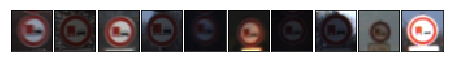

______________________________________________________________________________________

Class 11: Right-of-way at the next intersection               1170 samples


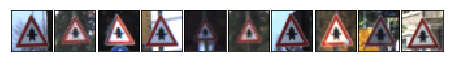

______________________________________________________________________________________

Class 12: Priority road                                       1890 samples


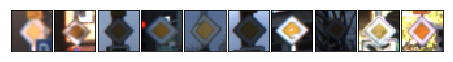

______________________________________________________________________________________

Class 13: Yield                                               1920 samples


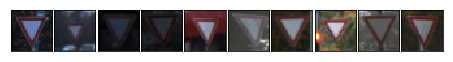

______________________________________________________________________________________

Class 14: Stop                                                690 samples


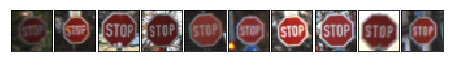

______________________________________________________________________________________

Class 15: No vehicles                                         540 samples


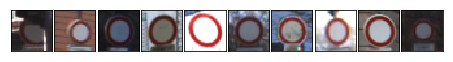

______________________________________________________________________________________

Class 16: Vehicles over 3.5 metric tons prohibited            360 samples


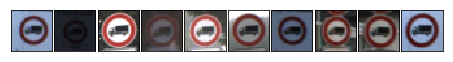

______________________________________________________________________________________

Class 17: no entry                                            990 samples


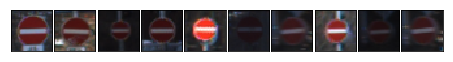

______________________________________________________________________________________

Class 18: general caution                                     1080 samples


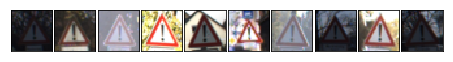

______________________________________________________________________________________

Class 19: Dangerous curve to the left                         180 samples


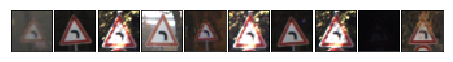

______________________________________________________________________________________

Class 20: Dangerous curve to the right                        300 samples


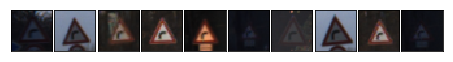

______________________________________________________________________________________

Class 21: Double Curve                                        270 samples


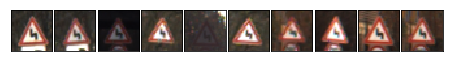

______________________________________________________________________________________

Class 22: Bumpy road                                          330 samples


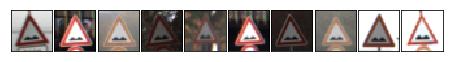

______________________________________________________________________________________

Class 23: Slippery road                                       450 samples


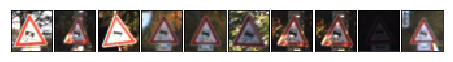

______________________________________________________________________________________

Class 24: Road narrows on the right                           240 samples


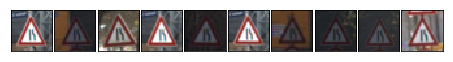

______________________________________________________________________________________

Class 25: Road work                                           1350 samples


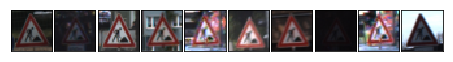

______________________________________________________________________________________

Class 26: Traffic signals                                     540 samples


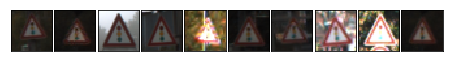

______________________________________________________________________________________

Class 27: Pedestrians                                         210 samples


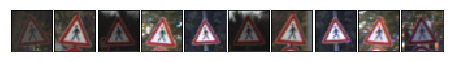

______________________________________________________________________________________

Class 28: Childen crossing                                    480 samples


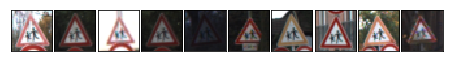

______________________________________________________________________________________

Class 29: Bicycles crossing                                   240 samples


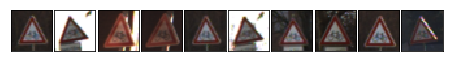

______________________________________________________________________________________

Class 30: Beware of ice/snow                                  390 samples


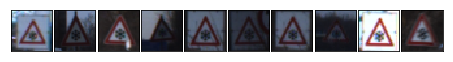

______________________________________________________________________________________

Class 31: Wild animals crossing                               690 samples


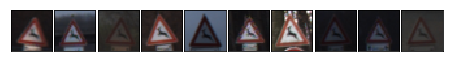

______________________________________________________________________________________

Class 32: End of all speed and passing limits                 210 samples


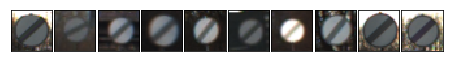

______________________________________________________________________________________

Class 33: Turn right ahead                                    599 samples


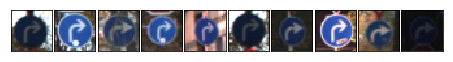

______________________________________________________________________________________

Class 34: Turn left ahead                                     360 samples


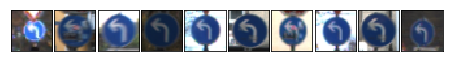

______________________________________________________________________________________

Class 35: Ahead Only                                          1080 samples


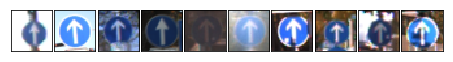

______________________________________________________________________________________

Class 36: Go stright or right                                 330 samples


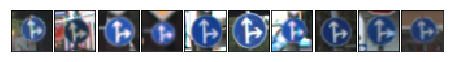

______________________________________________________________________________________

Class 37: Go straight or left                                 180 samples


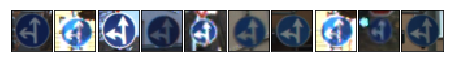

______________________________________________________________________________________

Class 38: Keep right                                          1860 samples


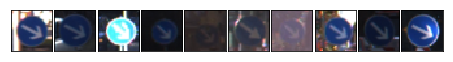

______________________________________________________________________________________

Class 39: Keep left                                           270 samples


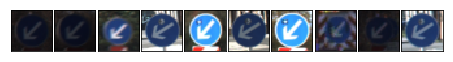

______________________________________________________________________________________

Class 40: Roundabout mandatory                                300 samples


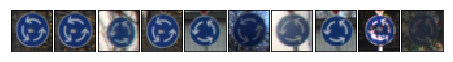

______________________________________________________________________________________

Class 41: End of no passing                                   210 samples


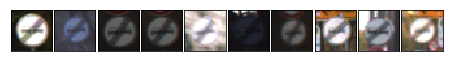

______________________________________________________________________________________

Class 42: End of no passing by vehicles over 3.5 metric tons  210 samples


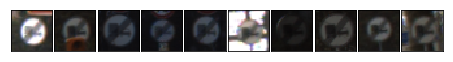

______________________________________________________________________________________



In [4]:
import random
sign_class_names = pd.read_csv("sign_class_names.csv").values[:, 1]
col_width = max(len(name) for name in sign_class_names)

for cls, cls_index, cls_count in zip(unique, index, counts):
    print("Class %i: %-*s  %s samples" % (cls, col_width, sign_class_names[cls], str(cls_count)))
    
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(cls_index, cls_index + cls_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    plt.show()
    print("______________________________________________________________________________________\n")

There is not a lot of training data given the number of classes, and a lot of classes only have a few hundred training images.

The images appear to be well centered, with small degrees of rotation present. 

There is a large variation in thebrightness, with some images looking washed out, and others almost too dark to recognize.

#### Convert to Grayscale

The images have three color channels, but many of the signs use the same color schemes and there is a higher variety of colors in the backgrounds than in the signs themselves, which may just add noise.  I will convert the images to grayscale for the initial modeling.

In [5]:
# Saving the 3-channel data in case it is needed later.
X_train_3c = X_train
X_test_3c = X_test

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]).reshape((-1,32,32,1))
    
X_train = rgb2gray(X_train)
X_test = rgb2gray(X_test)

print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)

(34799, 32, 32, 1) float64
(12630, 32, 32, 1) float64


#### Class Imbalance

There are 34,770 training images.  First I want to plot the number of images by class to see how imbalanced the classes are.

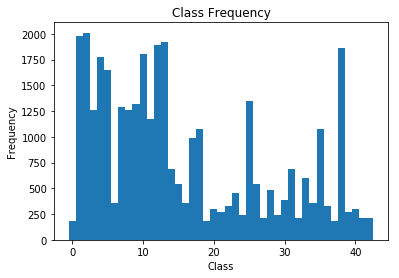

Maximum Class Count:  2010
Minimum Class Count:  180


In [7]:
n_classes, index, counts = np.unique(y_train, return_index = True, return_counts=True)

plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

print("Maximum Class Count: ", max(counts))
print("Minimum Class Count: ", min(counts))

There are quite a few classes with fewer than 500 training images, with some having as few as 180.  To generate additional training images, I will use a function to upsample the under-represented classes. I will sample the existing data with replacement, and for each new sample I will add a random rotation between -5 and +5 dergrees.

#### Generate Additional Training Data

In [8]:
from scipy.ndimage import rotate

def generate_additional_data_rotate(x, y):
    """Takes 4d numpy array of images x and class labels y,
    determines how many additional images per class to generate so that
    all classes have the same number of images, then generates additional
    images with rotation specified"""
    num_samples = len(x)
    classes, counts = np.unique(y, return_counts=True)
    num_classes = len(classes)
    max_class_count = max(counts)
    total_new_data = int((num_classes * max_class_count) - num_samples)
    
    x_additional = np.empty(shape = (total_new_data,32,32,1))
    y_additional = np.empty(shape = (total_new_data,))
    
    iteration = 0
    
    for i in range(num_classes):
        
        indexes = y == i   #Creates boolean array lenth 34,799
        count = np.sum(indexes)  # Counts total of samples per class for each iteration
        x_train_samples = x[indexes]  #Creates a 4d numpy array of the iteration's class
        y_train_samples = y[indexes] # creates 1d array of iteration's class
        num_new_samples = max_class_count - count
        
        for i in range(num_new_samples):
            
            sample_index = np.random.choice(count) # Pulls a random number from number of images in class
            x_sample = x_train_samples[sample_index] # Creates a sample image
            random_angle = 10.0 * np.random.random_sample(1) - 5.0
            x_new = rotate(x_sample, random_angle, axes=(0,1), reshape=False)#.reshape(1,32,32,1) #Create new image
            y_new = y_train_samples[0].reshape(1,) # Create new label
            x_additional[iteration] = x_new #adds new image to next spot in empty array
            y_additional[iteration] = y_new #adds new label to next spot in empty array
            iteration = iteration + 1

    return x_additional, y_additional

In [9]:
X_train_new, y_train_new = generate_additional_data_rotate(X_train, y_train)

In [10]:
X_train = np.concatenate((X_train, X_train_new))
y_train = np.concatenate((y_train, y_train_new))

In [11]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)

image_shape = (X_train[0].shape)

unique, index, counts = np.unique(y_train, return_index = True, return_counts=True)

n_classes = len(unique)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 86430
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


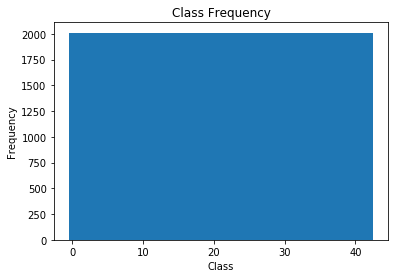

In [12]:
n_classes, index, counts = np.unique(y_train, return_index = True, return_counts=True)

plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Classes are now balanced, with 2010 images each.

#### Prepare Training Data for Modelling

In [13]:
X_train = X_train.astype(np.uint8)
y_train = y_train.astype(np.uint8)

In [14]:
def one_hot_array(nparray):
    one_hot_array = np.zeros((nparray.size, nparray.max()+1))
    one_hot_array[np.arange(nparray.size), nparray] = 1
    return one_hot_array

In [15]:
y_train_2 = one_hot_array(y_train)
y_test_2 = one_hot_array(y_test)

In [16]:
print(y_train_2.shape, y_train_2.dtype)
print(y_test_2.shape, y_test_2.dtype)

(86430, 43) float64
(12630, 43) float64


In [17]:
img_size = X_train.shape[1]

img_size_flat = X_train.shape[1] ** 2 * 3

num_classes = len(unique)

num_channels = X_train.shape[3]

print(X_train.shape)
print(y_train.shape)

(86430, 32, 32, 1)
(86430,)


## TensorFlow Graph Building Functions

#### Function to Generate New Weights

In [18]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

#### Function to Generate New Convolutional Layer

In [19]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

#### Function to Create Flattenening Later

In [20]:
# Turns 4D output into 2D

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

#### Function to Create New Fully Connected later

In [21]:
def new_fully_conn_layer(input,
                         num_inputs,
                         num_outputs,
                         use_relu = True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

#### Placeholder Variables

In [22]:
# For input images
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1], name='x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# Placeholder variable for the true labels associated with images in input placeholder variable x.
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_class = tf.argmax(y_true, axis=1)

## Building the TensorFlow Graph

#### Hyperparameters

In [23]:
# Configuration of Neural Network

# Convolutional Layer 1
filter_size1 = 5
num_filters1 = 16

# Convolutional Layer 2
filter_size2 = 5
num_filters2 = 36

# Fully Connected Layer 1
fc_size = 516

# Fully Connected Layer 2
fc2_size = 360

# Fully Connected Layer 3 - Output
fc3_size = 43

# Train Batch Size
train_batch_size = 64

# Learning Rate
learning_rate = 0.0001

#### Convolutional Layer 1

In [24]:
conv_layer_1, conv_weights_1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

print(conv_layer_1)

Tensor("Relu:0", shape=(?, 16, 16, 16), dtype=float32)


#### Convolutional Layer 2

In [25]:
conv_layer_2, conv_weights_2 = \
    new_conv_layer(input=conv_layer_1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

print(conv_layer_2)

Tensor("Relu_1:0", shape=(?, 8, 8, 36), dtype=float32)


#### Flatten Layer

In [26]:
layer_flat, num_features = flatten_layer(conv_layer_2)

print(layer_flat)
print(num_features)

Tensor("Reshape_1:0", shape=(?, 2304), dtype=float32)
2304


#### Fully Connected Layer 1

In [27]:
fully_conn_layer_1 = new_fully_conn_layer(input=layer_flat,
                                          num_inputs=num_features,
                                          num_outputs=fc_size,
                                          use_relu=True)

print(fully_conn_layer_1)

Tensor("Relu_2:0", shape=(?, 516), dtype=float32)


#### Fully Connected Layer 2

In [28]:
fully_conn_layer_2 = new_fully_conn_layer(input=fully_conn_layer_1,
                                          num_inputs=fc_size,
                                          num_outputs=fc2_size,
                                          use_relu=True)

print(fully_conn_layer_2)

Tensor("Relu_3:0", shape=(?, 360), dtype=float32)


#### Fully Connected Layer 3 - Output Layer

In [29]:
fully_conn_layer_3 = new_fully_conn_layer(input= fully_conn_layer_2,
                                          num_inputs=fc2_size,
                                          num_outputs=fc3_size,
                                          use_relu=False)

print(fully_conn_layer_3)

Tensor("add_4:0", shape=(?, 43), dtype=float32)


#### Predicted Class

In [30]:
y_pred = tf.nn.softmax(fully_conn_layer_3)
y_pred_class = tf.argmax(y_pred, axis=1)
print(y_pred_class)

Tensor("ArgMax_1:0", shape=(?,), dtype=int64)


#### Cost Function to be Optimized

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fully_conn_layer_3,
                                                       labels=y_true)
cost = tf.reduce_mean(cross_entropy)

print(cost)

Tensor("Mean:0", shape=(), dtype=float32)


#### Optimization Method

In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

#### Performance Measures

In [33]:
correct_prediction = tf.equal(y_pred_class, y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Run TensorFlow

In [34]:
session = tf.Session()
session.run(tf.global_variables_initializer())

#### Optimizer Function

In [35]:
total_iterations = 0
from sklearn.utils import shuffle

def optimize(num_iterations):
    # To update the the global variable rather than local copy
    global total_iterations
    num_examples = len(X_train)
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations + num_iterations):
        
        x_batch, y_true_batch = shuffle(X_train,y_train_2)
        
        batch_x, batch_y = x_batch[0 : train_batch_size], y_true_batch[0 : train_batch_size]
            
        feed_dict_train = {x: batch_x,
                          y_true: batch_y}
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            message = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            print(message.format(i + 1, acc))
            
    total_iterations += num_iterations
    
    end_time = time.time()
    
    time_diff = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

#### Function to Plot example errors

In [36]:
def plot_example_errors(class_pred, correct):
    
    incorrect = (correct == False)
    
    images = X_test[incorrect]
    
    class_pred = class_pred[incorrect]
    
    class_true = y_test[incorrect]
    
    plot_images(images=images[0:9],
               class_true=class_true[0:9],
               class_pred=class_pred[0:9])

#### Function to Plot Confusion Matrix

In [37]:
def plot_confusion_matrix(class_pred):
    
    class_true  = y_test
    
    cm = confusion_matrix(y_true=class_true,
                         y_pred=class_pred)
    
    print(cm)
    
    plt.figure(figsize=(11,11))
    plt.matshow(cm, fignum=1)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

#### Function to Print Test Accuracy

In [38]:
# Split the test-set into smaller batches of this size.
test_batch_size = 32

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(y_test)   ###data.num_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    class_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :]

        # Get the associated labels.
        labels = y_test_2[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        class_pred[i:j] = session.run(y_pred_class, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    class_true = y_test   ######NEEDS FIXED###########  OK NOW???

    # Create a boolean array whether each image is correctly classified.
    correct = (class_true == class_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(class_pred=class_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(class_pred=class_pred)

## Begin Training Iterations

#### 100 Iterations

In [39]:
optimize(num_iterations=100)

Optimization Iteration:      1, Training Accuracy:   3.1%
Time usage: 0:00:35


Accuracy on Test-Set: 16.4% (2071 / 12630)
Confusion Matrix:
[[  4   4  14 ...   2   0   0]
 [ 61  45 163 ...  36   5   7]
 [ 38  36 181 ...  26   3   1]
 ...
 [  0   1   3 ...   9   0   0]
 [  0   1  23 ...   0   4  13]
 [  0   7   4 ...   1  14  16]]


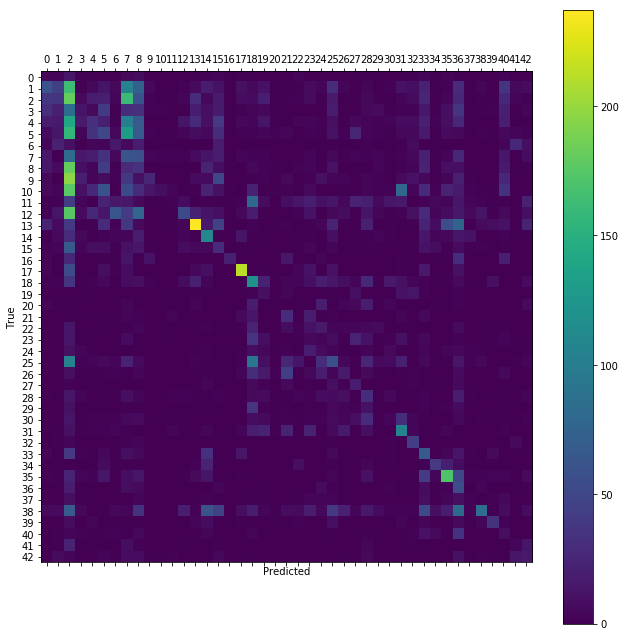

100


In [40]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 1000 Iterations

In [41]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  21.9%
Optimization Iteration:    201, Training Accuracy:  53.1%
Optimization Iteration:    301, Training Accuracy:  68.8%
Optimization Iteration:    401, Training Accuracy:  70.3%
Optimization Iteration:    501, Training Accuracy:  76.6%
Optimization Iteration:    601, Training Accuracy:  84.4%
Optimization Iteration:    701, Training Accuracy:  76.6%
Optimization Iteration:    801, Training Accuracy:  87.5%
Optimization Iteration:    901, Training Accuracy:  85.9%
Time usage: 0:05:26


Accuracy on Test-Set: 73.1% (9230 / 12630)
Confusion Matrix:
[[  4   9   1 ...   0   0   0]
 [  3 427  40 ...   0   0   0]
 [  1  29 418 ...   1   0   0]
 ...
 [  0   0   1 ...  46   0   0]
 [  0   0   0 ...   0  45   0]
 [  0   0   0 ...   0   6  67]]


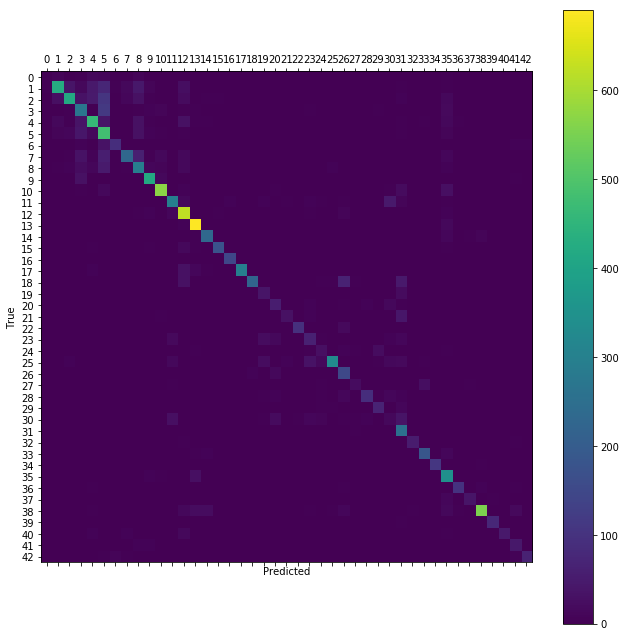

1000


In [42]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 5000 Iterations

In [43]:
optimize(num_iterations=4000)

Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy:  92.2%
Optimization Iteration:   1201, Training Accuracy:  92.2%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  93.8%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy:  98.4%
Optimization Iteration:   1901, Training Accuracy: 100.0%
Optimization Iteration:   2001, Training Accuracy:  93.8%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy: 100.0%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 86.6% (10941 / 12630)
Confusion Matrix:
[[ 14  26   0 ...   0   0   0]
 [  2 646  39 ...   0   0   0]
 [  0  14 693 ...   0   0   0]
 ...
 [  0   6   2 ...  63   0   0]
 [  0   0   0 ...   0  48   0]
 [  0   0   0 ...   0   1  80]]


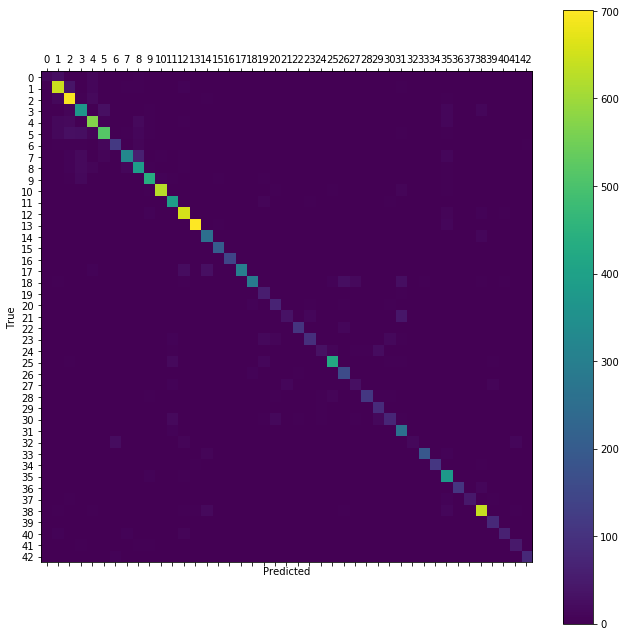

5000


In [44]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 10000 Iterations

In [ ]:
optimize(num_iterations=5000)

In [ ]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 20000 Iterations

In [ ]:
optimize(num_iterations=10000)

In [ ]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 30000 Iterations

In [ ]:
optimize(num_iterations=10000)

In [ ]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations)

#### 40000 Iterations

In [ ]:
optimize(num_iterations=10000)

In [ ]:
print_test_accuracy(show_confusion_matrix=True)
print(total_iterations